In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import math
import scipy

In [8]:
# p ='/home/kate/Documents/navigation/dataset/2018.12.29/2018.12.29_2_Analysis.mat'
# f = scipy.io.loadmat(p)
# f['Analysis'] # ???

In [2]:
def open_file(fpath, show=False):
    df = pd.read_csv(fpath, sep=" ", header = None, names=['numb', 'time', 'x', 'y'])
    df = df.drop(df[df.time > 1755].index)
    if show:
        x = df['x'].values.tolist()
        y = df['y'].values.tolist()
        plot_tajectory(x, y)
    return df

def plot_tajectory(x, y):
    time_cmap = np.arange(0, len(x))
    plt.scatter(x, y, s=1, c=time_cmap)
    plt.plot(x, y, c='gray', alpha=0.4)
    plt.scatter(0, 0, marker='X', s=60, c='red')
    plt.colorbar()
    plt.show()

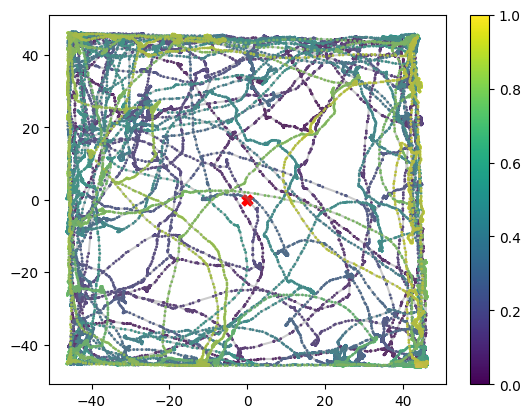

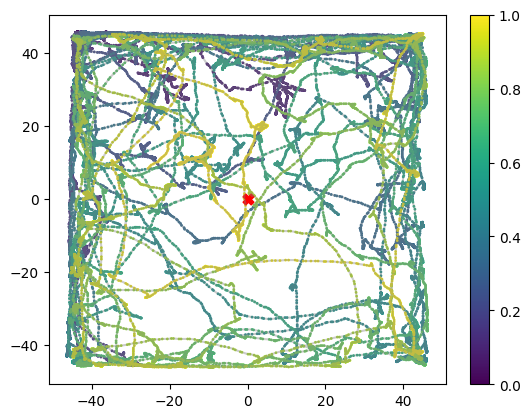

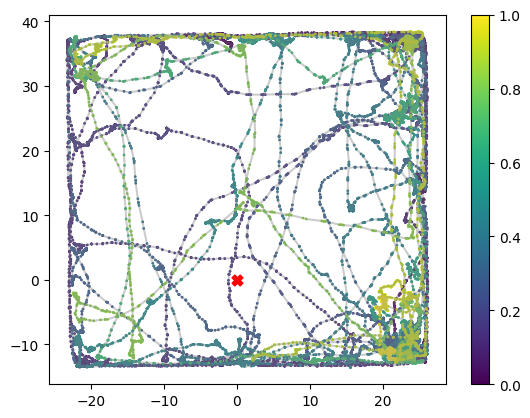

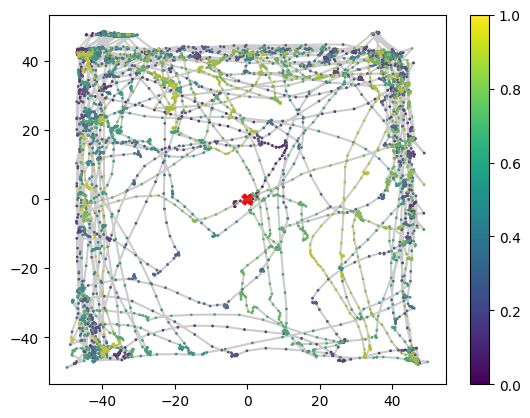

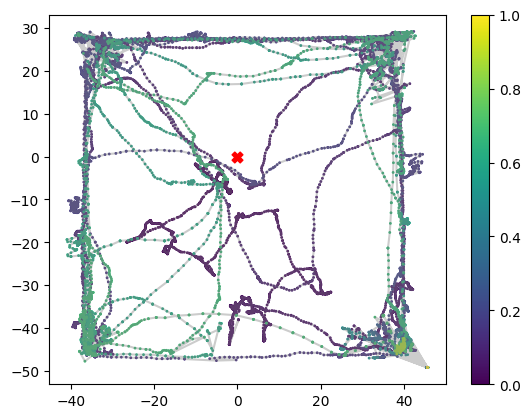

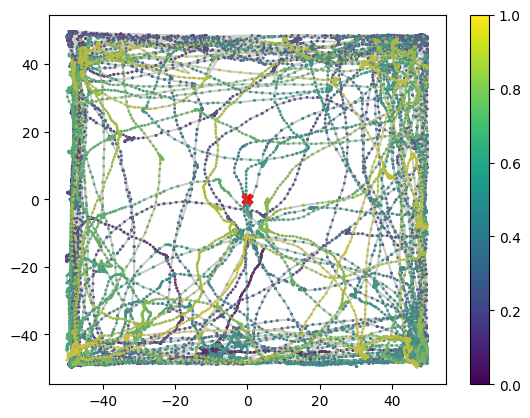

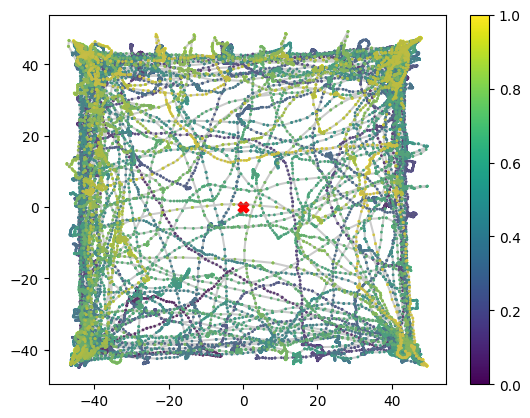

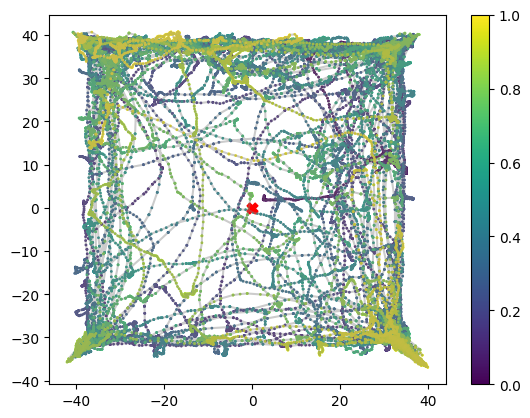

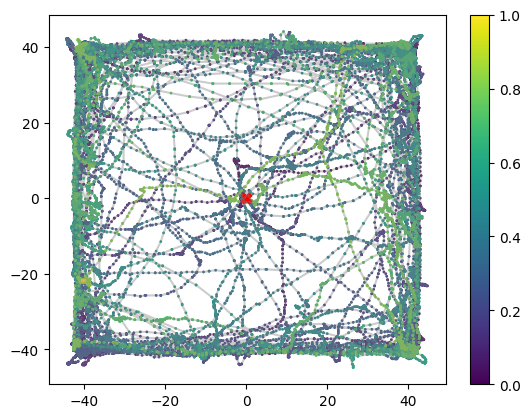

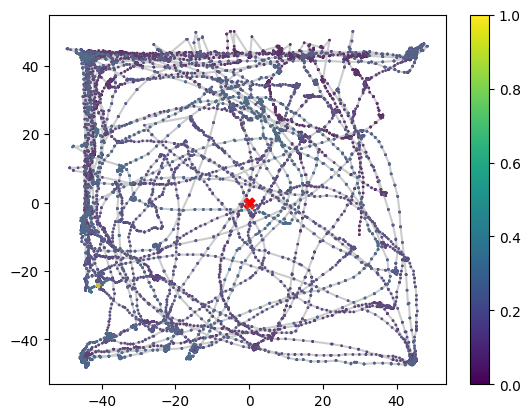

In [3]:
data_pathes = ['dataset/2018.12.08/after_floor_change/change_Trace.txt',
               'dataset/2018.12.08/before_floor_change/control_30min_Trace.txt',
               'dataset/2018.12.29/2018.12.29_2_Trace.txt',
               'dataset/2021. 01.20_metki_yes/sost_Trace.txt',
               'dataset/2021.01.19_metki_no/V_19.01.2021_Trace.txt',
               'dataset/2021.01.21_metki_yes/V_2_90_90_Trace.txt',
               'dataset/2021.02.27_metki_yes/V27.02.2021_Trace.txt',
               'dataset/2021.03.12_metki_yes_jump/V_2021_03_12_Trace.txt',
               'dataset/2021.06.16_1-2_days_metki_yes/2021.06.16_1-2_days_metki_yes/1_day_metki_yes/All_854_480_Trace.txt',
               'dataset/2021.06.16_1-2_days_metki_yes/2021.06.16_1-2_days_metki_yes/2_day_metki_yes/All_854_480_2day_Trace.txt',
               ]
# names = ['tr4', 'tr3', 'tr5', 'tr6', 'tr7', 'tr91', 'tr92', 'tr1', 'tr2']

dfs = []
for p in data_pathes:
    dfs.append(open_file(p, show=True))

In [4]:
def add_filtered_V(df):

    dt = df['time'].diff()
    vx = df['x'].diff() / dt
    vy = df['y'].diff() / dt
    v = (vx**2 + vy**2)**0.5

    dt[0], vx[0], vy[0] = 0., 0., 0.
    v[0] = 0.
    df.insert(3, 'Vx', pd.Series(gaussian_filter1d(vx, 5)))
    df.insert(4, 'Vy', pd.Series(gaussian_filter1d(vy, 5)))
    df.insert(5, 'V', pd.Series(gaussian_filter1d(v, 5)))

    return(df)

# ddf = dfs[0]
# dff = add_filtered_V(ddf)
# x = dff['x'].values.tolist()
# y = dff['y'].values.tolist()
# plot_tajectory(x, y)

# print('Derivative:')
# V_x = dff['Vx'].values.tolist()
# V_y = dff['Vy'].values.tolist()
# plot_tajectory(V_x, V_y)

In [5]:
filtered_Vdf_list = []
for dataframe_idx in dfs:
    filtered_Vdf_list.append(add_filtered_V(dataframe_idx))

In [9]:
def minmax_normalize(x):
    return (x - x.min()) / (x.max() - x.min())


def speed_z_score_norm(vx, vy, mean, sd):
    vb = ((vx ** 2) + (vy ** 2)) ** 0.5
    vn = abs((vb - mean) / sd)
    vx = vn * vx / vb
    vy = vn * vy / vb
    return vx, vy


def kill_nans(x, grid_size, verbose=False):
    for i in range(grid_size):
        for j in range(grid_size):
            if np.isnan(x.iloc[i, j]):
                if verbose:
                    print(f'NaN in place: {i}, {j}')
                idx_list = np.array([[i-1, j-1], [i-1, j], [i-1, j+1],
                                        [i, j-1]  ,           [i, j+1],
                                        [i+1, j-1], [i+1, j], [i+1, j+1]])
                
                idx_to_drop = np.where((idx_list < 0) | (idx_list > grid_size-1))[0]
                if verbose:
                    print(f'Dropping indexes: {idx_to_drop}')
                dropping_mask = np.ones(idx_list.shape[0], dtype=bool)
                dropping_mask[idx_to_drop] = False
                idx_list = idx_list[dropping_mask]

                x.iloc[i, j] = np.nanmean(x.iloc[idx_list[:, 0], idx_list[:, 1]])
    return x


def build_vector_field(df, grid_size,
                       title_name, z_norm,
                       lscale=0.17, color_map='Reds',
                       unsmoothed_colors=False, save=False):
    eps = 0.1
    ind = range(0, len(df))
    df = df.reindex(ind)  # TODO: ??? # reset idx?

    binx = np.linspace(df["x"].min() - eps, df["x"].max() + eps,
                       grid_size+1)
    x_binned = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min() - eps, df["y"].max() + eps,
                       grid_size+1)
    y_binned = pd.cut(df.y, biny, right=False)

    df_binned_mean = df.groupby([x_binned, y_binned],
                                 observed=False).mean()
    dfvx = pd.DataFrame(df_binned_mean.loc[:, 'Vx']).unstack()
    dfvy = pd.DataFrame(df_binned_mean.loc[:, 'Vy']).unstack()

    # For z_normalization
    if z_norm:
        df_binned_sd = df.groupby([x_binned, y_binned],
                                observed=False).std()
        mV = pd.DataFrame(df_binned_mean.loc[:, 'V']).unstack()
        sdV = pd.DataFrame(df_binned_sd.loc[:, 'V']).unstack()
        mV =  kill_nans(mV, grid_size)
        sdV = kill_nans(sdV, grid_size)

    # Average Nans with all neightboring values
    dfvx = kill_nans(dfvx, grid_size)
    dfvy = kill_nans(dfvy, grid_size)

    vector_field_matrix = []
    for i in range(grid_size):
        vector_column = []
        for j in range(grid_size):
            if z_norm:
                vx, vy = speed_z_score_norm(dfvx.iloc[i, j], dfvy.iloc[i, j],
                                            mV.iloc[i, j], sdV.iloc[i, j]) 
            else: 
                vx = dfvx.iloc[i, j]
                vy = dfvy.iloc[i, j]

            vector_column.append([binx[i], biny[j], vx, vy])
        vector_field_matrix.append(vector_column)

    vector_field_matrix = np.array(vector_field_matrix)

    vectx = vector_field_matrix[:, :, 2]
    vecty = vector_field_matrix[:, :, 3]
    vectx_smoothed = gaussian_filter(vectx, sigma=1)
    vecty_smoothed = gaussian_filter(vecty, sigma=1)

    L_matrix = (vectx_smoothed**2 + vecty_smoothed**2)**0.5
    L_matrix_unsmoothed = (vectx**2 + vecty**2)**0.5 

    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    ax.axvline(0, c='black', alpha=0.2)
    ax.axhline(0, c='black', alpha=0.2)
    
    L = L_matrix_unsmoothed if unsmoothed_colors else L_matrix
    min_val, max_val = np.min(L), np.max(L)
    cmap = plt.cm.get_cmap(color_map)
    color_list = cmap(L)

    for i in range(grid_size):
        for j in range(grid_size):
            l = L_matrix[i, j]
            im1 = ax.quiver(vector_field_matrix[i, j, 0],
                            vector_field_matrix[i, j, 1],
                            vectx_smoothed[i, j], vecty_smoothed[i, j],
                            color=color_list[i, j], units='xy', pivot='middle',
                            scale=lscale*l, width=0.6)
    plt.title(f"Vector Field of Speed, {title_name}")

    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_clim(vmin=min_val, vmax=max_val)
    plt.colorbar(sm, ax=ax)
    ax.set_facecolor('#CACACA')
    if save:
        plt.savefig(os.path.join(os.getcwd(), 'images',
                                 title_name + '_NewVelocityField.png'),
                    dpi=150)
    plt.show()

In [11]:
# build_vector_field(dff, grid_size=10,
#                    title_name='test_NORMALIZED',
#                    z_norm=True,
#                    lscale=0.17,
#                    color_map='Reds',
#                    unsmoothed_colors=False, save=False)

# build_vector_field(dff, grid_size=10,
#                    title_name='test',
#                    z_norm=False,
#                    lscale=0.17,
#                    color_map='Reds',
#                    unsmoothed_colors=False, save=False)

/tmp/ipykernel_10879/2483506491.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(color_map)


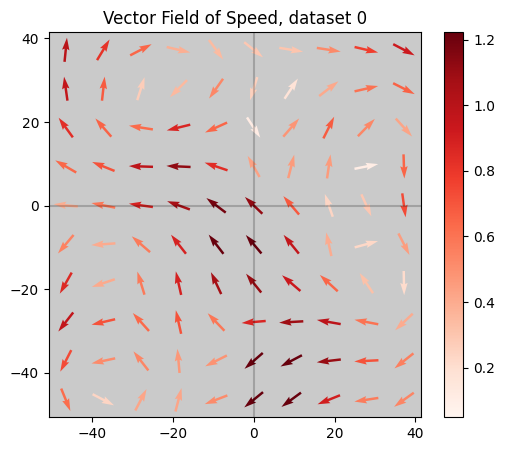

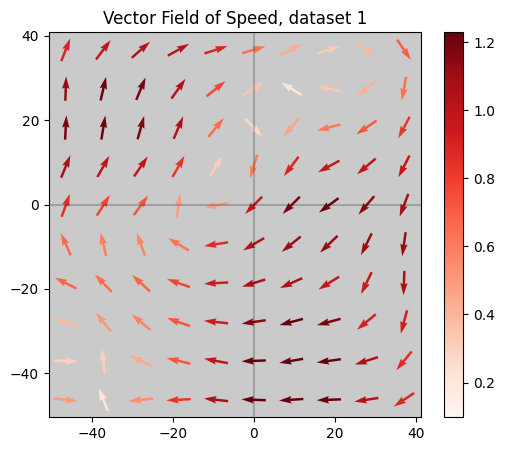

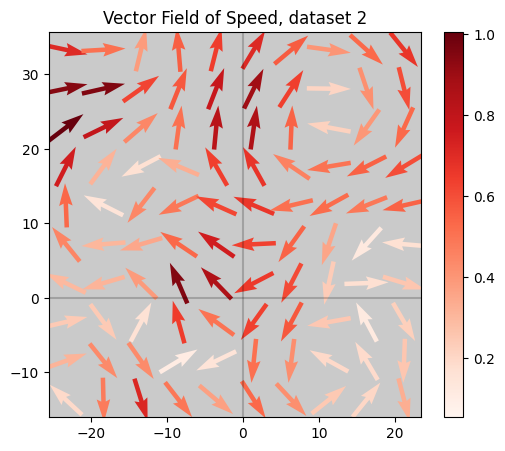

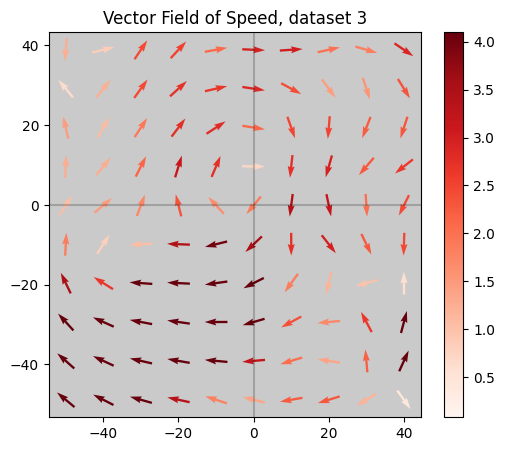

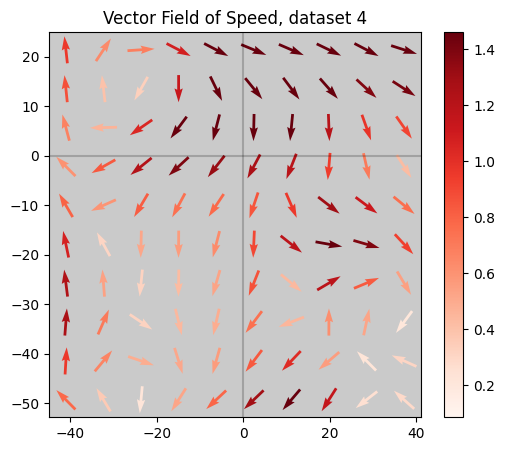

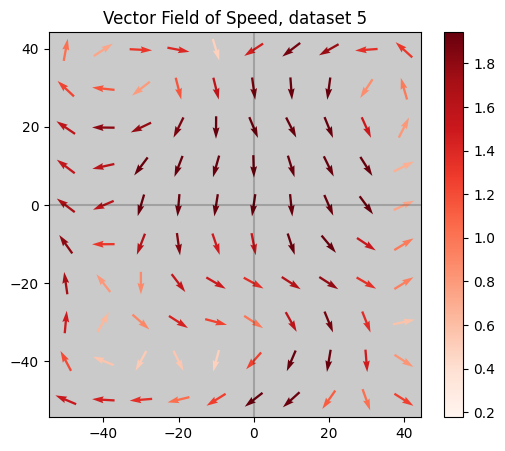

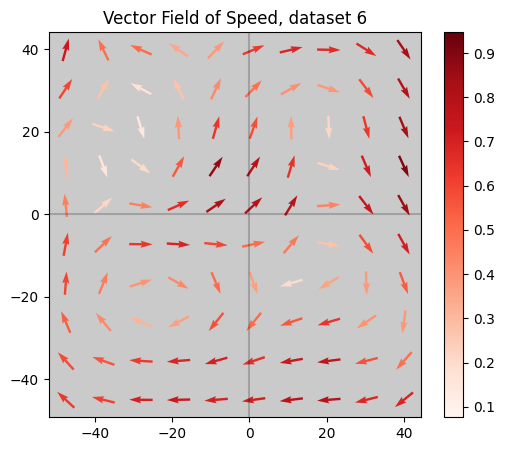

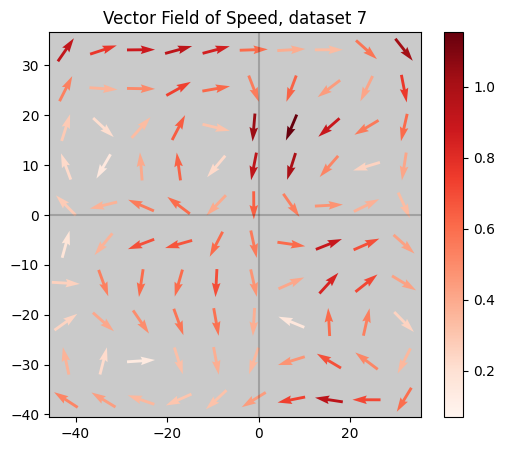

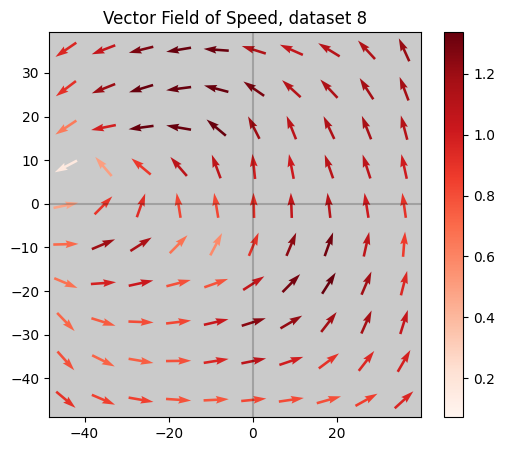

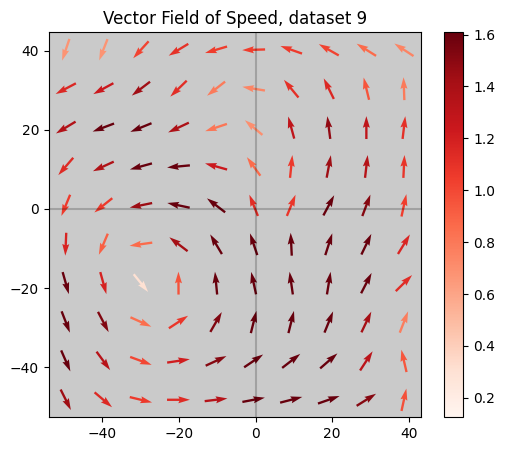

In [19]:
for i, filtered_df in enumerate(filtered_Vdf_list):
# for i, filtered_df in enumerate(dfs):

    build_vector_field(filtered_df,
                       grid_size=10,
                       title_name=f'dataset {i}',
                       z_norm=True,
                       lscale=0.17,
                       color_map='Reds',
                       unsmoothed_colors=False,
                       save=False)

### Plotting of turning maps

In [14]:
def normalize(y):
    exceeded_indices = np.where(y > 2*np.pi)[0]
    if len(exceeded_indices) > 0:
        y[exceeded_indices] = np.fmod(y[exceeded_indices], 2*np.pi)
    return y

def plotTurnsMap(df, grid_size,
                title_name, z_norm,
                color_map='twilight',
                save=False):
    eps = 0.1
    ind = range(0, len(df))
    df = df.reindex(ind)

    binx = np.linspace(df["x"].min() - eps, df["x"].max() + eps,
                       grid_size+1)
    x_binned = pd.cut(df.x, binx, right=False)
    biny = np.linspace(df["y"].min() - eps, df["y"].max() + eps,
                       grid_size+1)
    y_binned = pd.cut(df.y, biny, right=False)

    df_binned_mean = df.groupby([x_binned, y_binned],
                                 observed=False).mean()
    dfvx = pd.DataFrame(df_binned_mean.loc[:, 'Vx']).unstack()
    dfvy = pd.DataFrame(df_binned_mean.loc[:, 'Vy']).unstack()

    # For z_normalization
    if z_norm:
        df_binned_sd = df.groupby([x_binned, y_binned],
                                observed=False).std()
        mV = pd.DataFrame(df_binned_mean.loc[:, 'V']).unstack()
        sdV = pd.DataFrame(df_binned_sd.loc[:, 'V']).unstack()
        mV =  kill_nans(mV, grid_size)
        sdV = kill_nans(sdV, grid_size)

    # Average Nans with all neightboring values
    dfvx = kill_nans(dfvx, grid_size)
    dfvy = kill_nans(dfvy, grid_size)

    vector_field_matrix = []
    for i in range(grid_size):
        vector_column = []
        for j in range(grid_size):
            if z_norm:
                vx, vy = speed_z_score_norm(dfvx.iloc[i, j], dfvy.iloc[i, j],
                                            mV.iloc[i, j], sdV.iloc[i, j]) 
            else: 
                vx = dfvx.iloc[i, j]
                vy = dfvy.iloc[i, j]

            vector_column.append([binx[i], biny[j], vx, vy])
        vector_field_matrix.append(vector_column)

    vector_field_matrix = np.array(vector_field_matrix)
    vectx = vector_field_matrix[:, :, 2]
    vecty = vector_field_matrix[:, :, 3]
    
    Xx = np.arctan2(vectx, vecty) + np.pi
    Nres = normalize(Xx)  
    arct = (np.rad2deg(Nres) + 180) % 360
    
    plt.figure(figsize=(5, 5))
    arct = np.rot90(arct)
    sns.heatmap(arct, cmap=color_map, square=True, 
                xticklabels=False, yticklabels=False)
    plt.title(title_name + ', average degrees')
    if save:
        plt.savefig(os.path.join(os.getcwd(), 'images',
                                 title_name + '_NewVelocityField.png'),
                    dpi=150)
    plt.show()
    
    return arct

In [15]:
# _ = plotTurnsMap(dff, grid_size=10,
#                 title_name='test',
#                 z_norm=True,
#                 color_map='twilight',
#                 save=False)

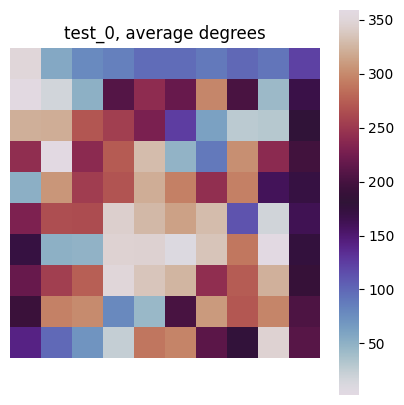

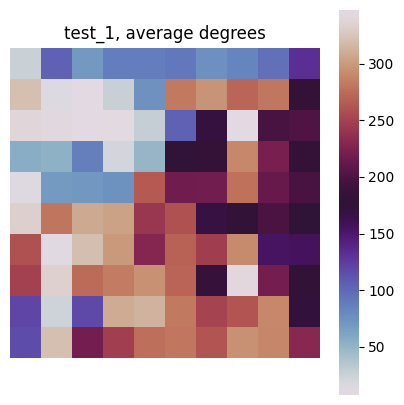

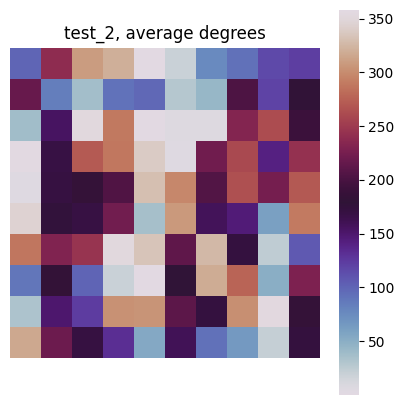

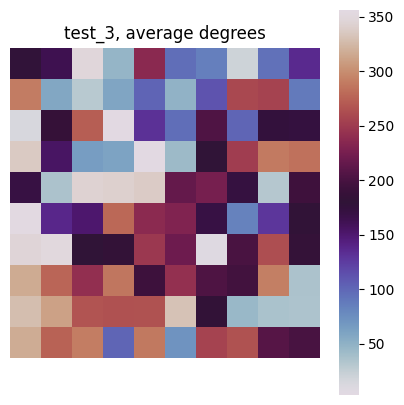

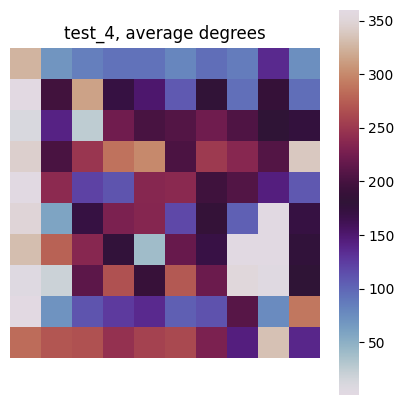

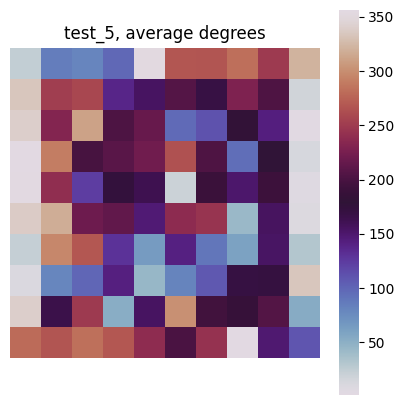

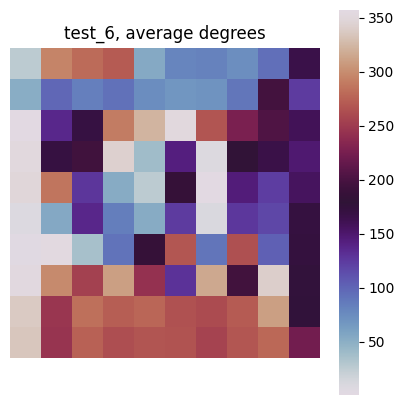

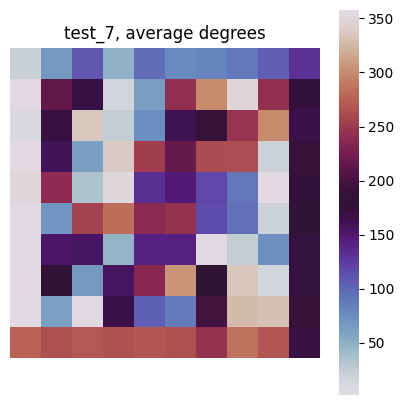

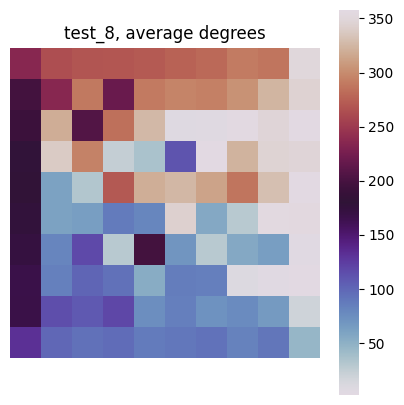

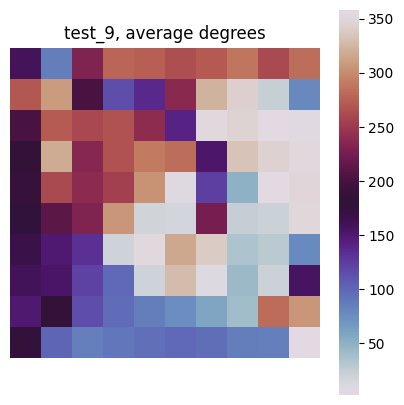

In [20]:
# for i, filtered_df in enumerate(filtered_Vdf_list):
for i, filtered_df in enumerate(dfs):
    _ = plotTurnsMap(filtered_df,
                     grid_size=10,
                     title_name=f'test_{i}',
                     z_norm=True,
                     color_map='twilight',
                     save=False)